# Histopathologic Cancer Detection

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from re import findall
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

2023-09-27 11:57:37.572266: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 11:57:37.679585: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 11:57:38.207099: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Ubuntu setting
from os import environ
environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda'

In [2]:
tf.config.list_physical_devices('GPU')

2023-09-27 11:04:32.964487: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 11:04:33.004387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 11:04:33.004518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## I. Brief Introduction

* Goal:

    The task of the project is to predict if tumors are on small pathology images. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.

* Data description

    1. Data for training and testing is named with an image ID, and we have 220,000 images for training. There are 57,500 images we need to predict if tumors are in the image.

    2. 

## Load

In [11]:
Path.home()

PosixPath('/home/ivan')

In [3]:
# Training images
# train_images = Path.cwd() /'CNN/train/'
train_images = Path.home() /'Desktop/CNN/CNN/train/'
train_image_path = [i.as_posix() for i in train_images.glob('*.tif')]
train_image_id = [findall(r'[^\/]+(?=\.)', i)[0] for i in train_image_path]
# Test images
# test_images = Path.cwd() /'CNN/test/' 
test_images = Path.home() /'Desktop/CNN/CNN/test/'
test_image_path = [i.as_posix() for i in test_images.glob('*.tif')]
# Dataset info
print(f"Number of images for training: {len(train_image_path)}")
print(f"Number of images for testing: {len(test_image_path)}")

Number of images for training: 220025
Number of images for testing: 57458


In [4]:
# Faster way to load images than matplotlib
train_image_data = np.array([np.array(Image.open(i), dtype='uint8') for i in train_image_path]).reshape(-1, 96, 96, 3)
train_image_data.shape

(220025, 96, 96, 3)

In [ ]:

test_image_data = np.array([np.array(Image.open(i), dtype='uint8') for i in test_image_path]).reshape(-1, 96, 96, 3)
test_image_data.shape

In [4]:
# Show the training data information
img = plt.imread(train_image_path[0])
print(f"Image data type: {type(img)}")
print(f"Image data shape: {img.shape}")

Image data type: <class 'numpy.ndarray'>
Image data shape: (96, 96, 3)


In [5]:
# df = pd.DataFrame({'path' : train_image_path})
# df['id'] = df['path'].apply(lambda x: findall(r'[^\/]+(?=\.)', x)[0])

# Create a dataframe to store the training data and metadata
df = pd.DataFrame({'id' : train_image_id,})
# Training labels
df_labels = pd.read_csv('/home/ivan/Desktop/CNN/CNN/train_labels.csv')
# Merge training data and labels
df_train = df.merge(df_labels, on = 'id')
# Data preview
df_train.head()

,id,label
0,d690c4e218b177a59cfe1b50b5f0a53bf22e3c94,1
1,04782f4fb3a08572ebc1ba378e6f7d0a74a83e43,0
2,b3175a20603a942482ff62af9e186ac8b42b3df1,0
3,356e0f57f7d8dc56aa8480d95dc4485f2c412391,1
4,7b6f37186925c4ce1720680bbcdfcb0197cf89a9,1


In [6]:
# Data info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   path    220025 non-null  object
 1   id      220025 non-null  object
 2   data    220025 non-null  object
 3   label   220025 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 6.7+ MB


In [7]:
# Create a dataframe to store the testing data and metadata
df_test = pd.DataFrame({'path' : test_image_path})
df_test['id'] = df_test['path'].apply(lambda x: findall(r'[^\/]+(?=\.)', x)[0])
df_test['data'] = df_test['path'].apply(lambda x: plt.imread(x)/255.0)
# Data preview
df_test.head()

In [9]:
# Save the train/test dataset for future use
path = '/home/ivan/Desktop/CNN/code/'
df_train[['id', 'data', 'label']].to_csv(path + 'train_data.csv', index=False)
df_test[['id', 'data']].to_csv(path + 'test_data.csv', index=False)

In [10]:
# Load ()failed
# df_train = pd.read_csv(path + 'train_data.csv')
# df_test = pd.read_csv(path + 'test_data.csv')

In [12]:
df_train.head()

,id,data,label
0,d690c4e218b177a59cfe1b50b5f0a53bf22e3c94,[[[246 248 247]\n [252 254 253]\n [247 253 2...,1
1,04782f4fb3a08572ebc1ba378e6f7d0a74a83e43,[[[242 241 239]\n [242 241 239]\n [242 241 2...,0
2,b3175a20603a942482ff62af9e186ac8b42b3df1,[[[255 254 245]\n [235 233 238]\n [245 243 2...,0
3,356e0f57f7d8dc56aa8480d95dc4485f2c412391,[[[201 178 196]\n [220 200 212]\n [243 226 2...,1
4,7b6f37186925c4ce1720680bbcdfcb0197cf89a9,[[[101 52 99]\n [ 32 0 23]\n [255 241 2...,1


In [18]:
# Convert the training images as tensor and apply normalization
img_array_train = df_train['data'].apply(lambda x: (x/255.0).reshape(-1, 96, 96, 3)).values
img_array_test = df_test['data'].apply(lambda x: (x/255.0).reshape(-1, 96, 96, 3)).values
# Concatenate all images
train_images = np.concatenate(img_array_train)
train_labels = df_train['label'].values
test_images = np.concatenate(img_array_test)
# Data info
print(f"Training data shape: {train_images.shape}")
print(f"Test data shape: {test_images.shape}")

: 

### Split

In [7]:
# Split 20% of training data for validation
train_labels = df_train['label'].values
X_train, X_val, y_train, y_val = train_test_split(train_image_data, train_labels, shuffle=True, test_size=0.2)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y val shape: {y_val.shape}")

X_train shape: (176020, 96, 96, 3)
y_train shape: (176020,)
X_val shape: (44005, 96, 96, 3)
y val shape: (44005,)


In [8]:
# Normalize pixel values to be between 0 and 1
X_train = np.true_divide(X_train, 255, dtype=np.float32)
X_val = np.true_divide(X_val, 255, dtype=np.float32)

In [ ]:
# NOTE !!! Don't run this, the kernel will crash
# Normalize pixel values to be between 0 and 1
# X_train, X_val, y_train, y_val = X_train / 255.0, X_val / 255.0, y_train / 255.0, y_val / 255.0

## Modeling

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 25600)             0

2023-09-27 12:01:55.618111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 12:01:55.658119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 12:01:55.658260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_val, y_val))

: 

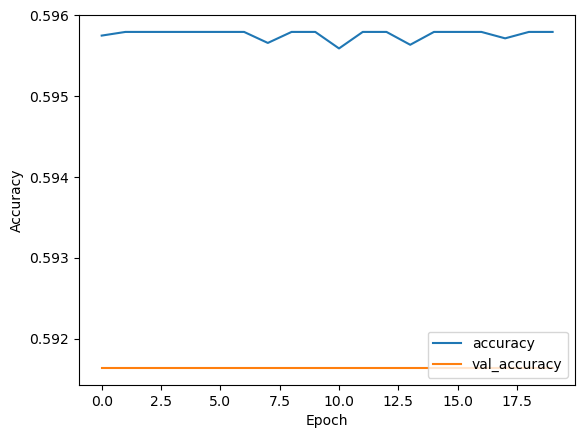

In [17]:
# Model evaluation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)